In [1]:
!pip install tensorflow
!pip install numpy
!pip install pandas
!pip install matplotlib


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app

# NN from scratch

Goal is to reproduce TensorFlow's Sequential from scratch.

Focus for now is on single output.

In [74]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from typing import List

## NN Class

Class of layers and networks (collection of layers in sequence)

In [116]:
class Layer():
    '''
    Class for each layer of the NN.
    '''
    def sigmoid(self, vec):
        return 1 / (1 + np.exp(-vec))
    
    def softplus(self, vec):
        return np.log(1 + np.exp(vec))

    def relu(self, vec):
        return np.maximum(vec, 0)
    
    def linear(self, vec):
        return vec

    def set_inputs(self, inputs):
        units = self.units
        self.inputs = inputs

        # Setup weights vector
        self.weights = np.zeros((inputs, units))


    def __init__(self, units, inputs=1, activation='reLU'):
        '''
        Initialization

        Variables:
        units - # of units, int
        inputs - # of inputs, int

        activation - activation func, function

        weights - ndarray (inputs, units), dtype = float64
        bias - ndarray (1, units), dtype = float64

        '''
        self.units = units


        if activation == "sigmoid":
            self.activation = self.sigmoid
        elif activation == "softplus":
            self.activation = self.softplus
        elif activation == "reLU":
            self.activation = self.relu
        else:
            # linear as default activation function
            self.activation = self.linear

        self.bias = np.zeros((1, units))

        self.set_inputs(inputs)

    def forward_pass(self, input_vector : np.ndarray):
        '''
        Forward pass
        
        Parameters:
        input_vector : ndarray (inputs, 1)

        Returns:
        output_vector : ndarray(units, 1)
        '''
        x = (np.matmul(input_vector.T, self.weights)) + self.bias
        x = x.T
        return self.activation(x)
    
    __call__ = forward_pass
    
    def set_weights(self, weight_vector : np.ndarray):
        '''
        Manually set weights

        Parameters:
        weight_vector : ndarray (inputs, units)
        '''

        self.weights = weight_vector

    def set_bias(self, bias_vector : np.ndarray):
        '''
        Manually set weights

        Parameters:
        bias_vector : ndarray (1, units), dtype = float64
        '''

        self.bias = bias_vector 
    

        
# Basic test
test = Layer(2)

test_a1 = np.array([[1], [2]])

test.set_weights(np.array([[1.5, 0.3],[2.6, 0.8]]))
test.set_bias(np.array([[1.2,1.4]]))

assert np.array_equal(test(test_a1),np.array([[7.9], [3.3]]))



In [117]:
class NeuralNetwork():
    '''
    Neural Network class
    '''
    def __init__(self, layers : List[Layer]):
        '''
        Setup Neural Network from a list of layers

        Initializes inputs automatically besides the first layer
        '''

        self.layers = layers

        for i in range(1, len(layers)):
            prev_layer_outputs = layers[i - 1].weights.shape[1]

            layers[i].set_inputs(prev_layer_outputs)

    def forward_pass(self, input_vector : np.ndarray):
        '''
        Forward pass thru whole network
        
        Parameters:
        input_vector : ndarray (inputs, 1)

        Returns:
        output_vector : ndarray (units, 1)
        '''

        for i in range(len(self.layers)):
            input_vector = self.layers[i].forward_pass(input_vector)
        return input_vector
    
    __call__ = forward_pass


### Testing from simple NN given in StatQuest video

ReLU Test - Looks good


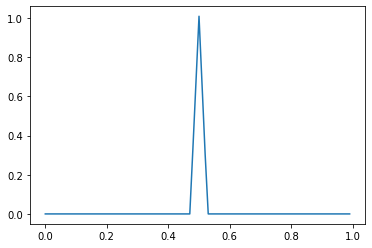

In [118]:
layer1 = Layer(2)

output_layer = Layer(1)
test_from_statquest = NeuralNetwork([
    layer1, output_layer
])

layer1.set_weights(np.array([[1.7,12.6]]))
layer1.set_bias(np.array([[-.85,-.00]]))


output_layer.set_weights(np.array([[-40.8], [2.7]]))
output_layer.set_bias(np.array([[-16]]))

t = np.arange(0, 1, 0.01).reshape((1, -1))
plt.plot(t.flatten(), test_from_statquest(t).flatten())

Sigmoid test

2.2315619419837787

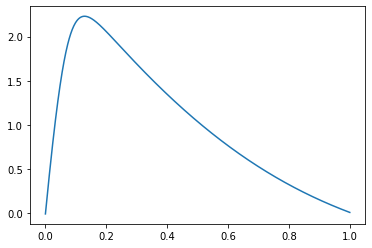

In [119]:
layer1 = Layer(2, activation="softplus")

output_layer = Layer(1, activation="linear")
test_from_statquest = NeuralNetwork([
    layer1, output_layer
])

layer1.set_weights(np.array([[-34.4,-2.52]]))
layer1.set_bias(np.array([[2.14,1.29]]))


output_layer.set_weights(np.array([[-1.30], [2.28]]))
output_layer.set_bias(np.array([[-.58]]))


t = np.arange(0, 1, 0.001).reshape((1, -1))
plt.plot(t.flatten(), test_from_statquest(t).flatten())


## Forward Propagation

asdfasd
